In [29]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, MaskedColumn
from scipy.spatial import cKDTree as KDTree
from tqdm.notebook import tqdm

In [2]:
prod = '/home/aalvarez/Work/Data/SC8/PHZ_Prod_18oct2021/'

In [3]:
ref = Table.read(os.path.join(prod, 'ProductionInputEcdmHandler/star_reference_sample_dir.dir/phot.fits'), hdu=1)
len(ref)

500000

In [4]:
target = Table.read(os.path.join(prod, 'GalaxyFilteringTask/star_catalog.fits'))
len(target)

5330

In [5]:
truth = Table.read(os.path.join(prod, 'NnpzStarSed/output_file.fits'))

In [6]:
config = dict()
exec(open(os.path.join(prod, 'data/nnpz_star_sed_07Jun2021-094516.conf')).read(), config)

In [30]:
# Missing bands!
ref_filters = config['reference_sample_phot_filters']
target_filters = config['target_catalog_filters']

ref_selected = []
target_selected = []
for rname, (tname, terr) in zip(ref_filters, target_filters):
    if not isinstance(target[tname], MaskedColumn) or not target[tname].mask.all():
        ref_selected.append(rname)
        target_selected.append((tname, terr))
print(len(ref_selected), ref_selected)

9 ['lsst/u', 'lsst/g', 'lsst/r', 'lsst/i', 'lsst/z', 'euclid/VIS', 'euclid/Y', 'euclid/J', 'euclid/H']


# Normalize the reference sample

In [31]:
ref_photo = np.zeros((len(ref), len(ref_selected)))
for i, fname in enumerate(ref_selected):
    ref_photo[:, i] = ref[fname]

In [32]:
ref_l2norm = ref_photo / np.sqrt(np.sum(ref_photo**2, axis=1, keepdims=True))

In [33]:
ref_normed = ref_photo / ref_l2norm

In [34]:
kdtree = KDTree(ref_normed)

# Load and normalize the target

In [35]:
target_photo = np.zeros((len(target), len(target_selected)))
for i, (fname, ferr) in enumerate(target_selected):
    target_photo[:, i] = target[fname]

In [36]:
target_normed = target_photo / np.sqrt(np.sum(target_photo**2, axis=1, keepdims=True))

In [37]:
target_mask = np.isnan(target_photo).sum(axis=1) == 0
target_mask = target_mask & (truth['FLAGS_1'] == 0)
target_mask.sum() / len(target)

0.6091932457786117

In [40]:
masked_normed = target_normed[target_mask]
masked_truth = truth[target_mask]

In [41]:
(target[target_mask]['OBJECT_ID'] == masked_truth['OBJECT_ID']).all()

True

# How many match?

In [67]:
_, ref_idx = kdtree.query(masked_norm, k=50000)

In [68]:
matched = []
for nn, cnn in zip(masked_truth['NEIGHBOR_IDS'], ref_idx):
    matched.append(np.in1d(nn, ref['ID'][cnn]).sum())

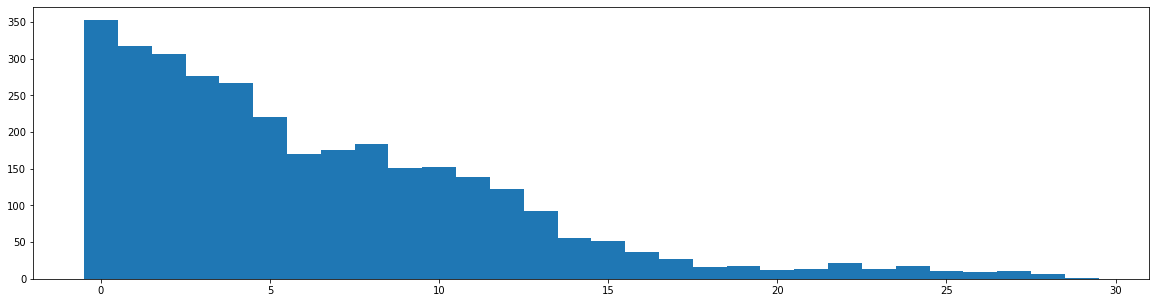

In [69]:
plt.figure(figsize=(20, 5))
plt.hist(matched, bins=np.arange(0, 31)-0.5)
plt.show()